In [15]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [16]:
#hyper params
lr = 1e-4
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 64
val_split = 0.85
test_split = 0.90
num_epoch = 20
num_classes = 2
classes = ['irrelevant','relevant']
path = './balanced_binary_dataset'

In [17]:

def get_dataset(path,val_split,test_split):
    data_transforms = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomCrop(size=256),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(path,transform=data_transforms)
    
    top_size = math.floor(len(dataset)*test_split)
    train_size = math.floor(len(dataset)*val_split)
    val_size = top_size - train_size
    test_size = len(dataset) - top_size
    topset,testset = data.random_split(dataset,lengths=[top_size,test_size])
    trainset,valset = data.random_split(topset,lengths=[train_size,val_size])
    
    print(len(trainset),len(valset),len(testset))
    
    return trainset,valset,testset

In [30]:
def train_model(trainset, valset, model, criterion, optimizer, scheduler, num_epochs,bs,hardness_threshold):
    dataloaders = {
        'train': data.DataLoader(trainset,batch_size=bs,shuffle=True),
        'val' : data.DataLoader(valset,batch_size=bs,shuffle=True)
    }
    dataset_sizes = {'train':len(trainset),'val':len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # List to store entropy values for each epoch
    entropy_values_train = []  
    entropy_values_val = []  
    #List to store loss of each epoch
    E_loss_train = []         
    E_loss_val = []
    # List to store balanced accuracy for training phase
    balanced_acc_train = []  
    balanced_acc_val = []    
    

          
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0
        all_labels = []
        all_preds = []
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy


            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #labels = torch.tensor(labels)
                labels = labels.to(device)
                #print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 

                    loss = criterion(outputs, labels)
                    
                    balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())  # Calculate balanced accuracy

                    all_labels.extend(labels.cpu().tolist())
                    all_preds.extend(preds.cpu().tolist())

                    
                    # Calculate hardness score for each sample in the batch
                    probabilities_hard = torch.softmax(outputs, dim=1)
                    hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]
                    #print('hardness score',hardness_scores)
                    
                    # Skip predictions if hardness score is greater than the threshold
                    skip_mask = hardness_scores <= hardness_threshold
                    if skip_mask.sum().item() > 0:
                        c+=1
                        inputs = inputs[skip_mask]
                        labels = labels[skip_mask]
                        preds = preds[skip_mask]
                        loss = criterion(outputs[skip_mask], labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            #confusion_matrix(preds, labels)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_entropy /= dataset_sizes[phase]  # Calculate average epoch entropy
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase,epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase,balanced_acc))
            print()
            
            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                #save epoch loss in a list
                E_loss_train.append(epoch_loss)
                #save epoch balanced loss in a list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training

            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                #save epoch loss in a list
                E_loss_val.append(epoch_loss)
                #save epoch balanced loss in a list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Apply weight decay to the parameters after each epoch
            for param in model.parameters():
                param.data -= lr * param.grad.data + wd * param.data
                
        print('Number of skipped:',c)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val

In [19]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []

    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [20]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [21]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [22]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        """ Resnet50
        """
        print("Resnet50")
        model_ft = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(2048,num_classes)
        #num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "mobilenet":
        """ Mobilenet_V2
        """
        print("Mobilenet_V2")
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            )
            #nu        #num_features = model.classifier[1].in_features
        #model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        """ VGG16_bn
        """
        print("VGG16_bn")
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)
        #num_ftrs = model_ft.classifier[6].in_features
        #model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "googlenet":
        """ googlenet
        """
        print("VGG16_bn")
        model_ft = torchvision.models.googlenet(weights='DEFAULT')
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(1024,num_classes)
        #model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        #model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        print("Densenet")
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier = nn.Linear(2208,num_classes)
        #num_ftrs = model_ft.classifier.in_features
        #model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run

# Print the model we just instantiated
#print(model_ft)


In [23]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()


In [24]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset, valset, testset = get_dataset(path, val_split, test_split)

26334 1549 3099


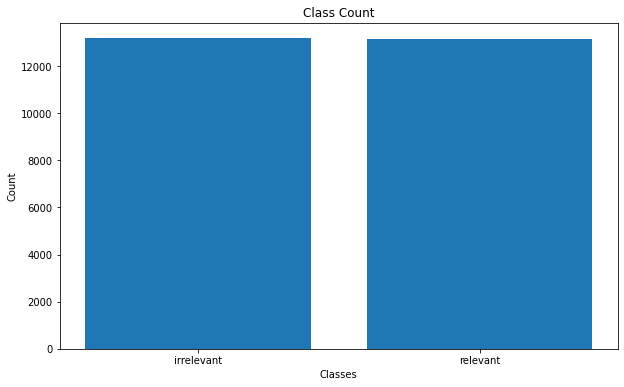

In [12]:
plot_distribution_by_class(trainset, classes)

Resnet50


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

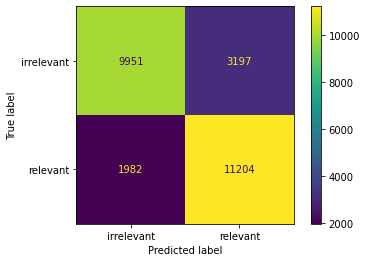

<Figure size 576x432 with 0 Axes>

val Loss: 0.4264 Acc: 0.8147
val Epoch Entropy: 0.5045
val Balanced Accuracy: 0.8571



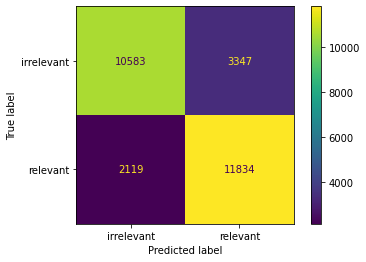

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 1/19
----------
train Loss: 0.4127 Acc: 0.8203
train Epoch Entropy: 0.5801
train Balanced Accuracy: 0.7667



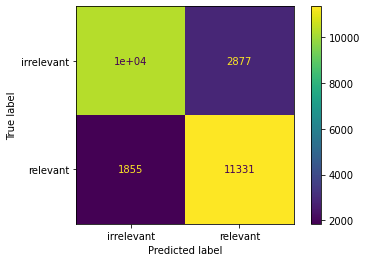

<Figure size 576x432 with 0 Axes>

val Loss: 0.4024 Acc: 0.8154
val Epoch Entropy: 0.5922
val Balanced Accuracy: 0.7857



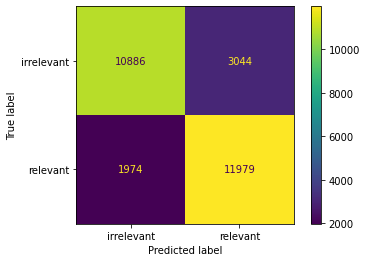

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 2/19
----------
train Loss: 0.4048 Acc: 0.8192
train Epoch Entropy: 0.5757
train Balanced Accuracy: 0.8947



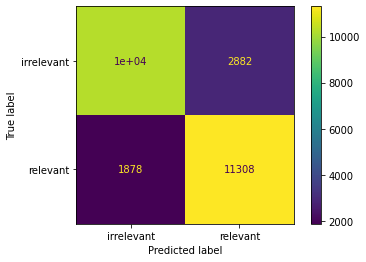

<Figure size 576x432 with 0 Axes>

val Loss: 0.4534 Acc: 0.7811
val Epoch Entropy: 0.6636
val Balanced Accuracy: 0.8750



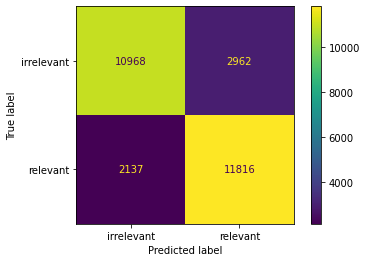

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 3/19
----------
train Loss: 0.4009 Acc: 0.8239
train Epoch Entropy: 0.5724
train Balanced Accuracy: 0.8333



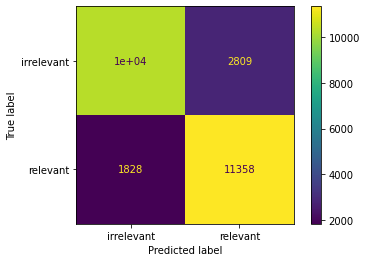

<Figure size 576x432 with 0 Axes>

val Loss: 0.4158 Acc: 0.8186
val Epoch Entropy: 0.5650
val Balanced Accuracy: 0.7333



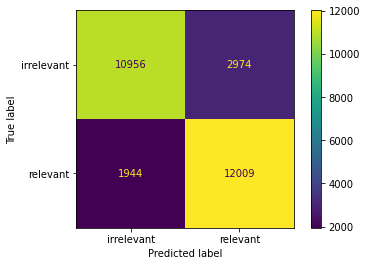

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 4/19
----------
train Loss: 0.3993 Acc: 0.8223
train Epoch Entropy: 0.5740
train Balanced Accuracy: 0.8973



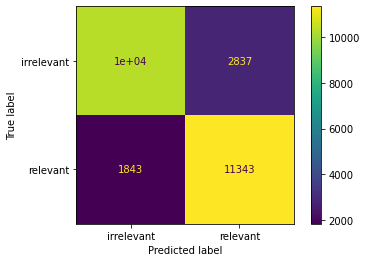

<Figure size 576x432 with 0 Axes>

val Loss: 0.4109 Acc: 0.8263
val Epoch Entropy: 0.5182
val Balanced Accuracy: 0.9167



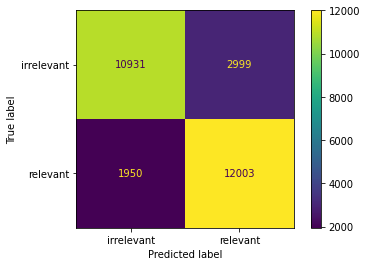

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 5/19
----------
train Loss: 0.3995 Acc: 0.8246
train Epoch Entropy: 0.5748
train Balanced Accuracy: 0.8301



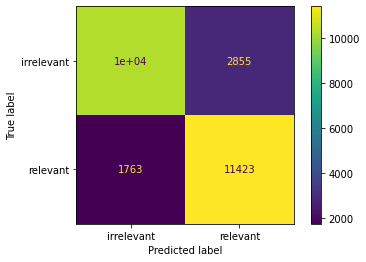

<Figure size 576x432 with 0 Axes>

val Loss: 0.4263 Acc: 0.8199
val Epoch Entropy: 0.6837
val Balanced Accuracy: 0.7639



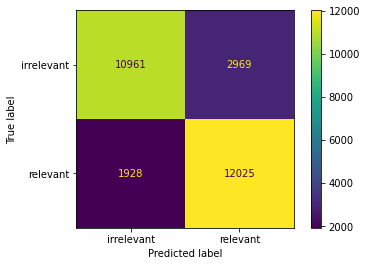

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 6/19
----------
train Loss: 0.3987 Acc: 0.8213
train Epoch Entropy: 0.5750
train Balanced Accuracy: 0.9019



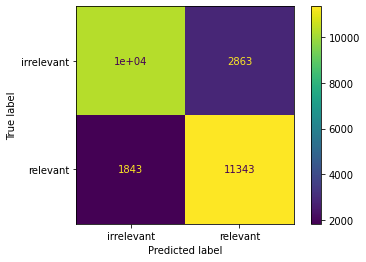

<Figure size 576x432 with 0 Axes>

val Loss: 0.4082 Acc: 0.8244
val Epoch Entropy: 0.6015
val Balanced Accuracy: 0.8375



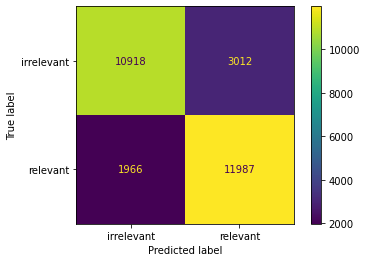

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 7/19
----------
train Loss: 0.3758 Acc: 0.8353
train Epoch Entropy: 0.5575
train Balanced Accuracy: 0.5714



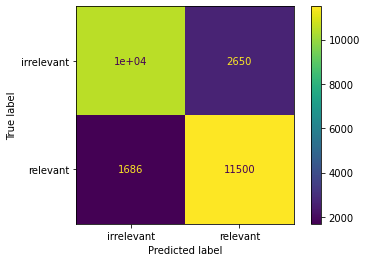

<Figure size 576x432 with 0 Axes>

val Loss: 0.3764 Acc: 0.8328
val Epoch Entropy: 0.5405
val Balanced Accuracy: 0.8000



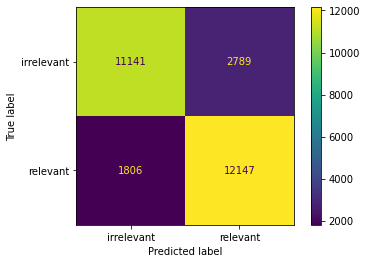

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 8/19
----------
train Loss: 0.3657 Acc: 0.8397
train Epoch Entropy: 0.5347
train Balanced Accuracy: 0.8750



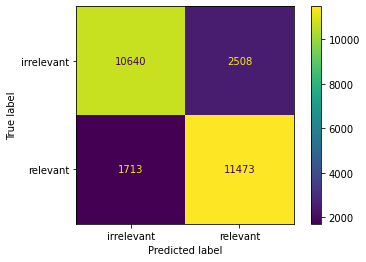

<Figure size 576x432 with 0 Axes>

val Loss: 0.3773 Acc: 0.8328
val Epoch Entropy: 0.5395
val Balanced Accuracy: 0.7857



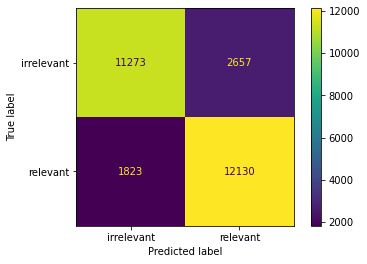

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 9/19
----------
train Loss: 0.3601 Acc: 0.8417
train Epoch Entropy: 0.5279
train Balanced Accuracy: 0.8667



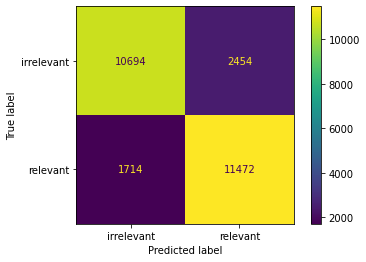

<Figure size 576x432 with 0 Axes>

val Loss: 0.3772 Acc: 0.8354
val Epoch Entropy: 0.5139
val Balanced Accuracy: 0.6750



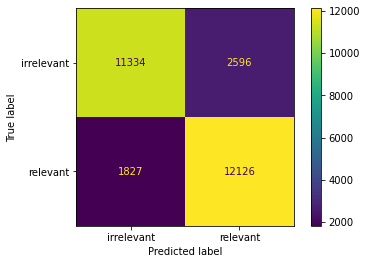

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 10/19
----------
train Loss: 0.3539 Acc: 0.8442
train Epoch Entropy: 0.5165
train Balanced Accuracy: 0.8000



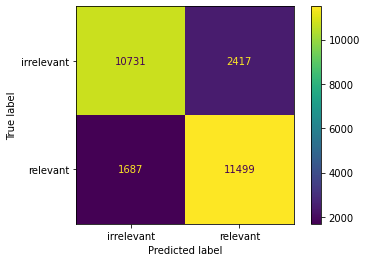

<Figure size 576x432 with 0 Axes>

val Loss: 0.3871 Acc: 0.8257
val Epoch Entropy: 0.5030
val Balanced Accuracy: 0.6190



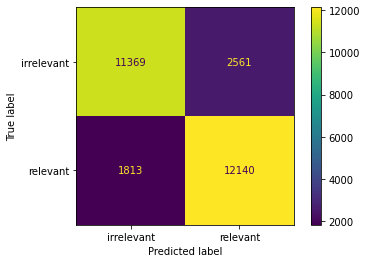

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 11/19
----------
train Loss: 0.3495 Acc: 0.8458
train Epoch Entropy: 0.5068
train Balanced Accuracy: 0.8643



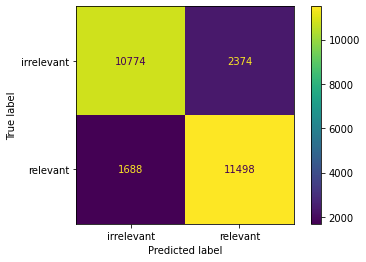

<Figure size 576x432 with 0 Axes>

val Loss: 0.3759 Acc: 0.8296
val Epoch Entropy: 0.5386
val Balanced Accuracy: 0.8500



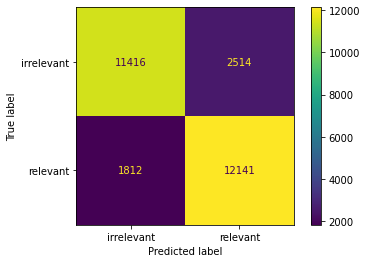

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 12/19
----------
train Loss: 0.3436 Acc: 0.8481
train Epoch Entropy: 0.5045
train Balanced Accuracy: 0.8259



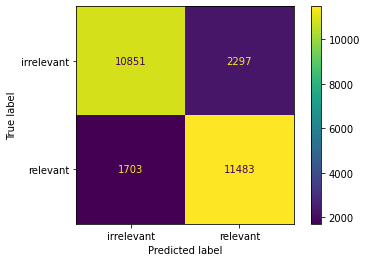

<Figure size 576x432 with 0 Axes>

val Loss: 0.3900 Acc: 0.8341
val Epoch Entropy: 0.4724
val Balanced Accuracy: 0.8452



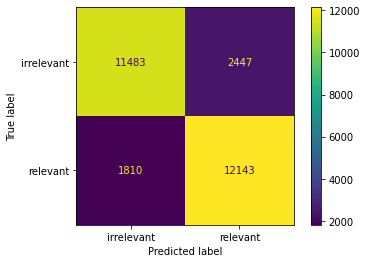

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 13/19
----------
train Loss: 0.3371 Acc: 0.8535
train Epoch Entropy: 0.4917
train Balanced Accuracy: 0.7723



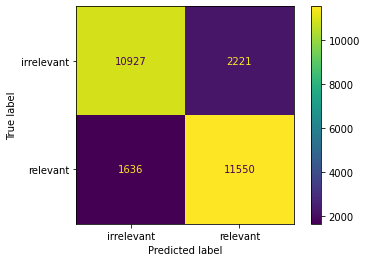

<Figure size 576x432 with 0 Axes>

val Loss: 0.3912 Acc: 0.8315
val Epoch Entropy: 0.4586
val Balanced Accuracy: 0.8500



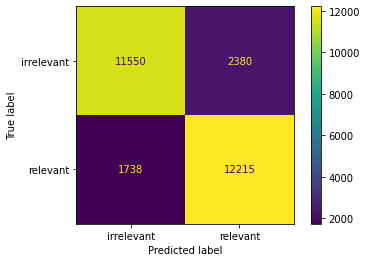

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 14/19
----------
train Loss: 0.3235 Acc: 0.8605
train Epoch Entropy: 0.4798
train Balanced Accuracy: 0.9000



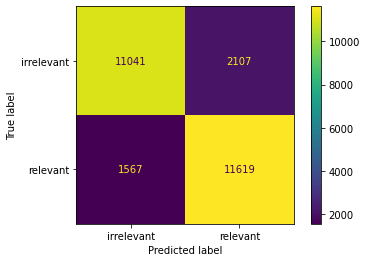

<Figure size 576x432 with 0 Axes>

val Loss: 0.3866 Acc: 0.8283
val Epoch Entropy: 0.4717
val Balanced Accuracy: 0.9286



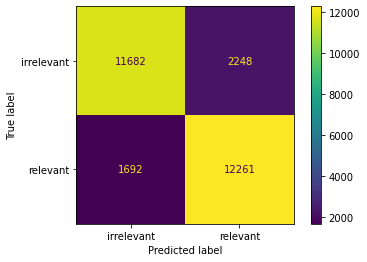

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 15/19
----------
train Loss: 0.3199 Acc: 0.8609
train Epoch Entropy: 0.4744
train Balanced Accuracy: 0.9027



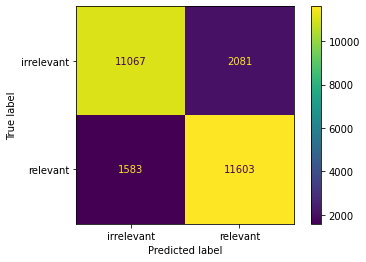

<Figure size 576x432 with 0 Axes>

val Loss: 0.3937 Acc: 0.8399
val Epoch Entropy: 0.4653
val Balanced Accuracy: 0.9167



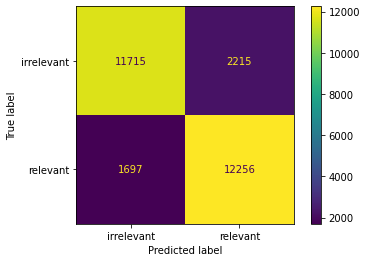

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 16/19
----------
train Loss: 0.3153 Acc: 0.8632
train Epoch Entropy: 0.4673
train Balanced Accuracy: 0.8036



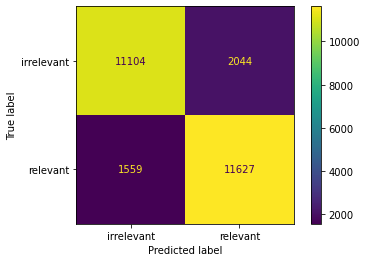

<Figure size 576x432 with 0 Axes>

val Loss: 0.3947 Acc: 0.8276
val Epoch Entropy: 0.4728
val Balanced Accuracy: 0.9000



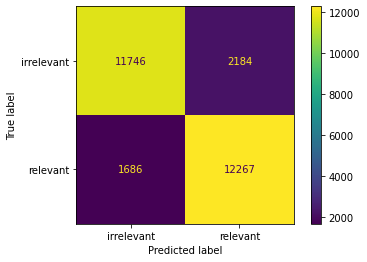

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 17/19
----------
train Loss: 0.3138 Acc: 0.8644
train Epoch Entropy: 0.4638
train Balanced Accuracy: 0.7679



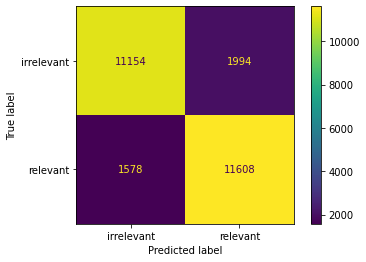

<Figure size 576x432 with 0 Axes>

val Loss: 0.3980 Acc: 0.8309
val Epoch Entropy: 0.4492
val Balanced Accuracy: 0.7500



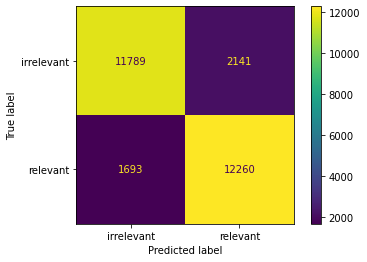

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 18/19
----------
train Loss: 0.3122 Acc: 0.8655
train Epoch Entropy: 0.4588
train Balanced Accuracy: 0.8472



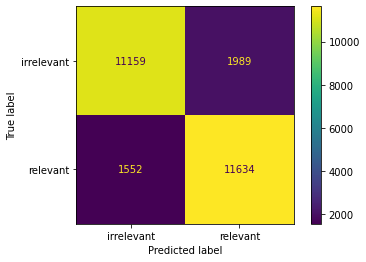

<Figure size 576x432 with 0 Axes>

val Loss: 0.4020 Acc: 0.8354
val Epoch Entropy: 0.4513
val Balanced Accuracy: 0.9000



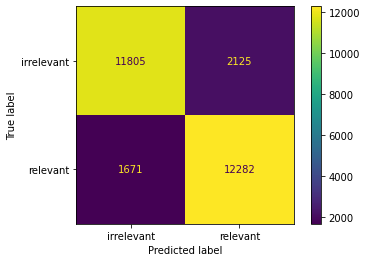

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Epoch 19/19
----------
train Loss: 0.3075 Acc: 0.8664
train Epoch Entropy: 0.4529
train Balanced Accuracy: 0.8750



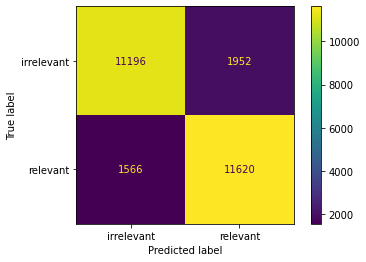

<Figure size 576x432 with 0 Axes>

val Loss: 0.4068 Acc: 0.8212
val Epoch Entropy: 0.4378
val Balanced Accuracy: 0.6750



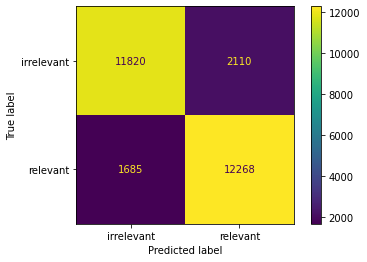

<Figure size 576x432 with 0 Axes>

Number of skipped: 437

Training complete in 68m 35s
Best val Acc: 0.839897


In [31]:
model_list = []
hardness_threshold = 0.75
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=wd)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset, valset, model, criterion, optimizer, exp_lr_scheduler, num_epoch, bs,hardness_threshold)
    


The Test Accuracy: tensor(0.8322, device='cuda:0')
The Test Balanced Accuracy: 0.8323192345275652


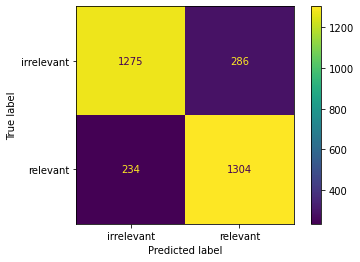

<Figure size 576x432 with 0 Axes>

None


In [32]:
print(test_model(model, testset))


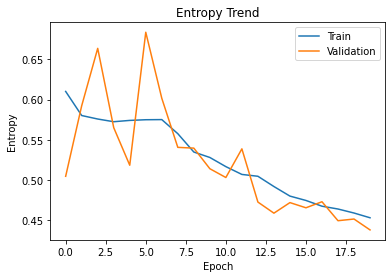

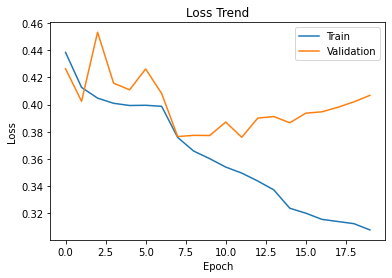

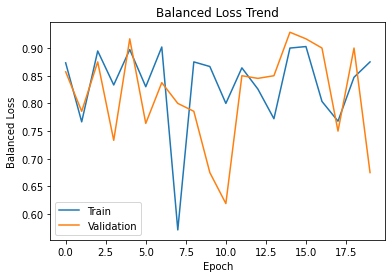

In [33]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [34]:
    
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

#Balanced Accuracy
balanced_acc = balanced_accuracy_score(test_Y, predictions)  # Calculate balanced accuracy


print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

print("Dummy Classifier Balanced Accuracy/ Random Baseline:", balanced_acc)



Dummy Classifier Accuracy/ Random Baseline: 0.5062923523717329
Dummy Classifier Balanced Accuracy/ Random Baseline: 0.4999260668655433


Accuracy for SVM: 0.8386576314940304
Balanced Accuracy:0.8388259751468041


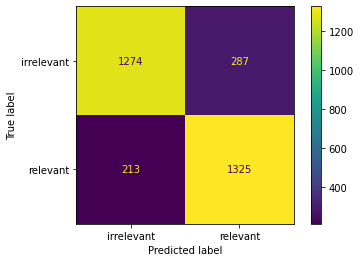

<Figure size 576x432 with 0 Axes>

In [37]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
#Balanced Accuracy
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))

# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()


Accuracy for MLP: 0.840593739916102
Balanced Accuracy:0.8407334500157864


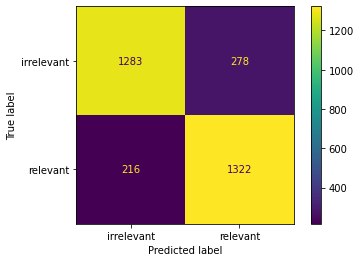

<Figure size 576x432 with 0 Axes>

In [38]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
#Balanced Accuracy
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))

# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()
